# Importing Required libraries

In [1]:
%run ./EODHD_Functions.ipynb
import requests
import pandas as pd
import datetime as dt
import numpy as np
import os as os
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.pyplot as mdates
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import numpy as np

# Functions used in this file

In [2]:
def Calculate_volatility(df, days=30, price_col='adjusted_close'):
    """
    Calculate the N-day annualized volatility of a stock from a DataFrame of prices.
    Assumes daily frequency.

    Parameters:
    df : DataFrame
        DataFrame containing price data.
    days : int
        Number of days to use for volatility calculation.
    price_col : str
        Column name for price data.

    Returns:
    volatility : float
        Annualized volatility.
    """
    df = df.copy()
    df['log_return'] = np.log(df[price_col] / df[price_col].shift(1))
    last_n = df['log_return'].dropna()[-days:]
    volatility = last_n.std() * np.sqrt(252)
    return volatility

# Creating blackscholes option pricing model

In [3]:

def black_scholes(S, K, T, r, sigma):
    """
    Calculate Black-Scholes option price for European call and put.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Risk-free interest rate (annual)
    sigma : float
        Volatility of the underlying asset (annual)

    Returns:
    call_price : float
        Price of the European call option
    put_price : float
        Price of the European put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return call_price, put_price

In [4]:
'''# Using black-scholes model to calculate option price

Function = EODHD_Functions()
end_date = dt.datetime.now()
days = 600
start_date = end_date - dt.timedelta(days=days)
s = Function.Fetch_historical_price("CA.PA", start_date,end_date,"d").iloc[-1]
T = 30/365
k = 12
r = 1.05
sigma = Calculate_volatility(Function.Fetch_historical_price("CA.PA", start_date,end_date,"d"),days)

CA_option_price = black_scholes(s['adjusted_close'], k, T, r/100, sigma)

print(f"Call Option Price: {CA_option_price[0]:.2f}, Put Option Price: {CA_option_price[1]:.2f}")'''

'# Using black-scholes model to calculate option price\n\nFunction = EODHD_Functions()\nend_date = dt.datetime.now()\ndays = 600\nstart_date = end_date - dt.timedelta(days=days)\ns = Function.Fetch_historical_price("CA.PA", start_date,end_date,"d").iloc[-1]\nT = 30/365\nk = 12\nr = 1.05\nsigma = Calculate_volatility(Function.Fetch_historical_price("CA.PA", start_date,end_date,"d"),days)\n\nCA_option_price = black_scholes(s[\'adjusted_close\'], k, T, r/100, sigma)\n\nprint(f"Call Option Price: {CA_option_price[0]:.2f}, Put Option Price: {CA_option_price[1]:.2f}")'

# Simulating jump diffusion stock price

In [7]:
def simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N):
    dt = T / N
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0
    for i in range(1, N+1):
        # Poisson jump
        Nj = np.random.poisson(lamb * dt)
        if Nj > 0:
            jumps = np.sum(np.random.normal(mu_j, sigma_j, Nj))
        else:
            jumps = 0
        dW = np.random.normal(0, np.sqrt(dt))
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW + jumps)
    return t, S


In [6]:
'''# Simulating jump diffusion model for a stock
# Parameters
S0 = s['adjusted_close']  # initial stock price as a float
mu = 0.05      # expected return
sigma = sigma   # volatility
lamb = 0.75   # average number of jumps per year
mu_j = -0.2   # mean of jump size (in log)
sigma_j = 0.1 # std dev of jump size (in log)
T = T         # time horizon (years)
N = 30       # number of steps (daily)

t, S = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)

plt.figure(figsize=(10,5))
plt.plot(t, S)
plt.title('Jump Diffusion Stock Price Simulation')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()
# Monte Carlo simulation for jump diffusion model
num_simulations = 1000000
all_paths = np.zeros((num_simulations, N+1))

for i in range(num_simulations):
    _, S_path = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)
    all_paths[i, :] = S_path

# Calculate statistics
mean_path = np.mean(all_paths, axis=0)
p10_path = np.percentile(all_paths, 10, axis=0)
p90_path = np.percentile(all_paths, 90, axis=0)

plt.figure(figsize=(10,5))
plt.plot(t, mean_path, label='Mean Path', color='blue')
plt.plot(t, p10_path, label='10th Percentile', color='red', linestyle='--')
plt.plot(t, p90_path, label='90th Percentile', color='green', linestyle='--')
plt.fill_between(t, p10_path, p90_path, color='gray', alpha=0.2, label='10-90 Percentile Range')
plt.title('Monte Carlo Jump Diffusion Simulation (1000 runs)')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the final values at the end of the simulation
print(f"Final Mean Value: {mean_path[-1]:.2f}")
print(f"Final 10th Percentile: {p10_path[-1]:.2f}")
print(f"Final 90th Percentile: {p90_path[-1]:.2f}")'''

'# Simulating jump diffusion model for a stock\n# Parameters\nS0 = s[\'adjusted_close\']  # initial stock price as a float\nmu = 0.05      # expected return\nsigma = sigma   # volatility\nlamb = 0.75   # average number of jumps per year\nmu_j = -0.2   # mean of jump size (in log)\nsigma_j = 0.1 # std dev of jump size (in log)\nT = T         # time horizon (years)\nN = 30       # number of steps (daily)\n\nt, S = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)\n\nplt.figure(figsize=(10,5))\nplt.plot(t, S)\nplt.title(\'Jump Diffusion Stock Price Simulation\')\nplt.xlabel(\'Time (years)\')\nplt.ylabel(\'Stock Price\')\nplt.grid(True)\nplt.show()\n# Monte Carlo simulation for jump diffusion model\nnum_simulations = 1000000\nall_paths = np.zeros((num_simulations, N+1))\n\nfor i in range(num_simulations):\n    _, S_path = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)\n    all_paths[i, :] = S_path\n\n# Calculate statistics\nmean_path = np.mean(all_paths, 

# Neural CGMY Model Input Requirements
# Neural Network-Enhanced Lévy Models


In [8]:
def simulate_cgmy(S0, mu, sigma, C, G, M, Y, T, N, seed=None):
    """
    Simulate a stock price path using the CGMY model (time-changed Lévy process).

    Parameters:
    S0 : float
        Initial stock price.
    mu : float
        Drift term.
    sigma : float
        Diffusion (Brownian motion) volatility.
    C : float
        Activity parameter (intensity of jumps).
    G : float
        Rate of exponential decay for negative jumps.
    M : float
        Rate of exponential decay for positive jumps.
    Y : float
        Tail heaviness parameter (0 < Y < 2).
    T : float
        Total time horizon (in years).
    N : int
        Number of time steps.
    seed : int or None
        Random seed for reproducibility.

    Returns:
    t : ndarray
        Array of time points.
    S : ndarray
        Simulated stock price path.
    """
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0

    # Simulate Brownian increments
    dW = np.random.normal(0, np.sqrt(dt), N)

    # Simulate CGMY jumps using compound Poisson approximation
    # For simplicity, we use a finite activity approximation (truncating small jumps)
    jump_intensity = C * (G**-Y + M**-Y)
    num_jumps = np.random.poisson(jump_intensity * T)
    jump_times = np.random.uniform(0, T, num_jumps)
    jump_sizes = np.random.choice([-1, 1], size=num_jumps) * \
        np.random.exponential(1.0 / np.array([G, M])[np.random.randint(0, 2, num_jumps)], num_jumps)
    jump_sizes *= np.random.pareto(Y, num_jumps)  # heavy-tailed jump sizes

    # Assign jumps to time steps
    jumps = np.zeros(N)
    for jt, js in zip(jump_times, jump_sizes):
        idx = min(int(jt / dt), N-1)
        jumps[idx] += js

    for i in range(1, N+1):
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[i-1] + jumps[i-1])

    return t, S

# Rough Heston model (forecasting volatility)

In [34]:
def simulate_rough_heston(T, N, v0, theta, kappa, sigma, H, rho=0.0, S0=1.0, mu=0.0, seed=None):
    """
    Simulate the rough Heston model for stochastic volatility forecasting using the Davies-Harte method for fBM.

    Parameters:
    T : float
        Total time horizon (in years).
    N : int
        Number of time steps.
    v0 : float
        Initial variance.
    theta : float
        Long-term mean of variance.
    kappa : float
        Mean reversion speed.
    sigma : float
        Volatility of volatility.
    H : float
        Hurst parameter (0 < H < 0.5).
    rho : float
        Correlation between asset and volatility (default 0.0).
    S0 : float
        Initial asset price (default 1.0).
    mu : float
        Drift of the asset (default 0.0).
    seed : int or None
        Random seed for reproducibility.

    Returns:
    t : ndarray
        Array of time points.
    S : ndarray
        Simulated asset price path.
    v : ndarray
        Simulated variance path.
    """
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    v = np.zeros(N+1)
    v[0] = v0
    S = np.zeros(N+1)
    S[0] = S0

    # Generate correlated Brownian motions
    Z1 = np.random.normal(size=N)
    Z2 = np.random.normal(size=N)
    dW1 = np.sqrt(dt) * Z1
    dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

    # Davies-Harte method for fBM increments (fixed for broadcasting)
    def davies_harte_fbm(N, H, T):
        dt = T / N
        g = np.zeros(2 * N)
        for k in range(0, N):
            g[k] = 0.5 * ((abs(k + 1) ** (2 * H)) - 2 * (abs(k) ** (2 * H)) + (abs(k - 1) ** (2 * H)))
        g[N:2*N-1] = g[1:N][::-1]
        g[2*N-1] = 0  # Ensure the last element is zero
        eigvals = np.fft.fft(g).real
        Z = np.random.normal(size=2 * N) + 1j * np.random.normal(size=2 * N)
        W = np.fft.ifft(np.sqrt(np.maximum(eigvals, 0)) * Z).real
        fbm = np.cumsum(W[:N]) * np.sqrt(dt)
        return fbm

    fbm_increments = davies_harte_fbm(N, H, T)

    for i in range(1, N+1):
        # Rough Heston volatility process (approximate)
        v[i] = np.abs(
            v[i-1] + kappa * (theta - v[i-1]) * dt +
            sigma * fbm_increments[i-1]
        )
        # Asset price process
        S[i] = S[i-1] * np.exp((mu - 0.5 * v[i-1]) * dt + np.sqrt(v[i-1]) * dW2[i-1])

    return t, S, v

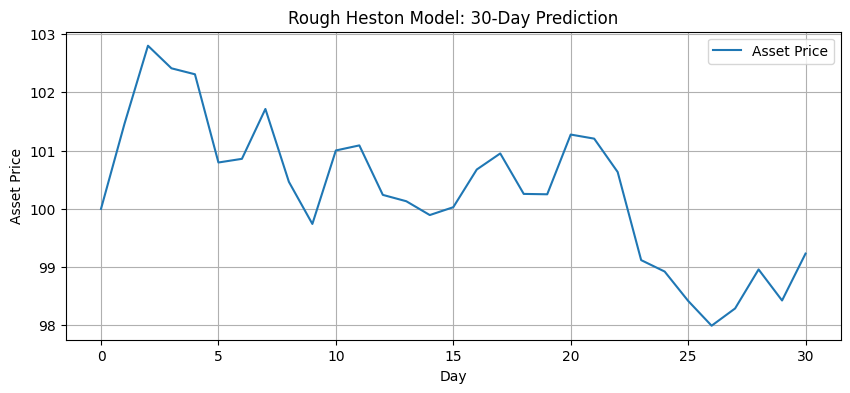

In [ ]:
# Example: Simulate rough Heston model and predict asset price for 30 days

# Parameters
T = 30 / 252         # 30 trading days (in years)
N = 30               # 30 time steps (daily)
v0 = 0.04            # Initial variance
theta = 0.04         # Long-term mean variance
kappa = 1.0          # Mean reversion speed
sigma = 0.5          # Volatility of volatility
H = 0.1              # Hurst parameter (roughness)
rho = -0.7           # Correlation
S0 = 100             # Initial asset price
mu = 0.05            # Drift
seed = None           # For reproducibility

# Simulate
t, S, v = simulate_rough_heston(T, N, v0, theta, kappa, sigma, H, rho, S0, mu, seed)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(t * 252, S, label='Asset Price')
plt.title('Rough Heston Model: 30-Day Prediction')
plt.xlabel('Day')
plt.ylabel('Asset Price')
plt.grid(True)
plt.legend()